In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'test school with markers   vel follow'
Experiment_note = """

"""

In [5]:
gpuId = 3
control_dt = 0.2
radius=1.0

max_time = 10

action_max= 2
couple_mode =  fl.COUPLE_MODE.TWO_WAY

wa= 1.0
wv = 5.0

use_markers=True
ratio = 0.005/control_dt*(max_time/10)
import torch
torch.cuda.set_device(gpuId)

In [6]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


In [7]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

# num_train_steps= int(1e6)
# replay_buffer_capacity=int(1e6)
# num_seed_steps=int(100)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [8]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=1
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [256,256]
n_critics = 2
# actor settings
actor_net_arch= [256,256]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



### Import Settings

In [9]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [10]:
fluid_json = json_folder+'fluid_param_school.json'
rigid_json = json_folder+'rigids_4_30_school.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_school.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_school.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [11]:
def plot_infos(infos,title=None,reward_fig_name=None):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    if title:
        plt.title(title)
    if reward_fig_name:
        plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [12]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [13]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [15]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

## RL Begin

In [16]:
from gym_fish.envs.fish_env_school import FishEnvSchool
env=FishEnvSchool(gpuId=gpuId,
                    couple_mode=couple_mode,control_dt=control_dt,max_time=max_time,
                    action_max=action_max,
                    rigid_json=rigid_json,use_markers=use_markers,
                     wa=wa,wv=wv,
                    fluid_json=fluid_json
                   ) 


In [17]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_space = env.action_space

In [18]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [19]:
logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
critic_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)
critic_target_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)

actor_network = DiagGaussianActor( obs_dim, action_dim, actor_net_arch,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_space,device,critic_network,critic_target_network,actor_network,replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [20]:
step = 0
next_eval_steps= eval_frequency

In [21]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                action = agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = env.step(action)
            action = agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [22]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [23]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=agent.predict(obs, deterministic=True)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [24]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Trajectory/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [25]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 16 | R: 19.2618 | D: 21.2 s | BR: 1.4444 | ALOSS: -3.0936 | CLOSS: 14.4878 | TLOSS: -0.0151 | TVAL: 0.9978 | AENT: -4.0000
| train | E: 2 | S: 31 | R: 18.4543 | D: 19.5 s | BR: 1.3687 | ALOSS: -4.0987 | CLOSS: 8.2655 | TLOSS: -0.0465 | TVAL: 0.9931 | AENT: -4.0000
| train | E: 3 | S: 52 | R: 32.6154 | D: 24.8 s | BR: 1.3817 | ALOSS: -6.0260 | CLOSS: 2.7521 | TLOSS: -0.0829 | TVAL: 0.9878 | AENT: -4.0000
| train | E: 4 | S: 78 | R: 48.9590 | D: 30.8 s | BR: 1.4870 | ALOSS: -7.0131 | CLOSS: 1.9459 | TLOSS: -0.1302 | TVAL: 0.9808 | AENT: -4.0000
| train | E: 5 | S: 92 | R: 16.0939 | D: 18.2 s | BR: 1.4737 | ALOSS: -7.0940 | CLOSS: 1.7651 | TLOSS: -0.1709 | TVAL: 0.9750 | AENT: -4.0000
| train | E: 6 | S: 110 | R: 27.2270 | D: 22.4 s | BR: 1.4428 | ALOSS: -7.2551 | CLOSS: 1.9537 | TLOSS: -0.2030 | TVAL: 0.9703 | AENT: -4.0000
| train | E: 7 | S: 127 | R: 23.9853 | D: 21.8 s | BR: 1.4835 | ALOSS: -7.4482 | CLOSS: 1.7979 | TLOSS: -0.2385 | TVAL: 0.9652 | AENT: -4.0000
| t

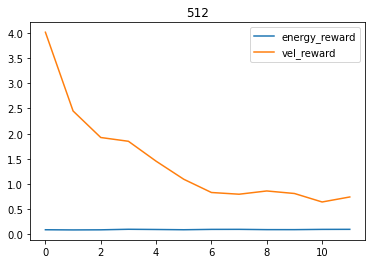

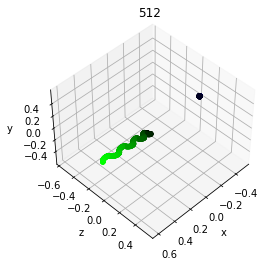

| eval  | E: 30 | S: 512 | R: 16.3209
| train | E: 31 | S: 512 | R: 35.2243 | D: 26.3 s | BR: 1.3814 | ALOSS: -11.5146 | CLOSS: 3.9051 | TLOSS: -1.0015 | TVAL: 0.8607 | AENT: -4.0000
| train | E: 32 | S: 530 | R: 26.8973 | D: 40.7 s | BR: 1.3826 | ALOSS: -11.6394 | CLOSS: 5.0861 | TLOSS: -1.0415 | TVAL: 0.8556 | AENT: -4.0000
| train | E: 33 | S: 544 | R: 16.8161 | D: 18.0 s | BR: 1.4087 | ALOSS: -12.1317 | CLOSS: 3.3177 | TLOSS: -1.0746 | TVAL: 0.8515 | AENT: -4.0000
| train | E: 34 | S: 562 | R: 29.1525 | D: 24.3 s | BR: 1.4325 | ALOSS: -12.0598 | CLOSS: 5.1745 | TLOSS: -1.1044 | TVAL: 0.8474 | AENT: -4.0000
| train | E: 35 | S: 578 | R: 20.6191 | D: 20.0 s | BR: 1.3828 | ALOSS: -12.0471 | CLOSS: 5.5563 | TLOSS: -1.1260 | TVAL: 0.8432 | AENT: -4.0000
| train | E: 36 | S: 592 | R: 18.3865 | D: 19.7 s | BR: 1.4015 | ALOSS: -12.3606 | CLOSS: 5.3755 | TLOSS: -1.1656 | TVAL: 0.8394 | AENT: -4.0000
| train | E: 37 | S: 608 | R: 21.0951 | D: 20.2 s | BR: 1.3844 | ALOSS: -12.4936 | CLOSS: 5.

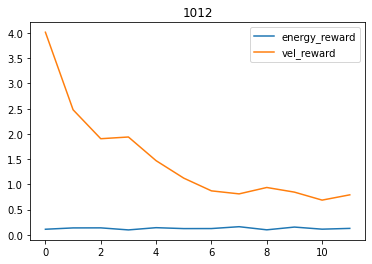

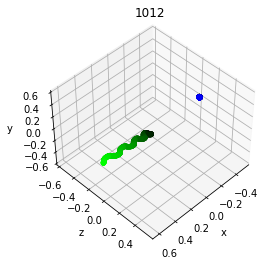

| eval  | E: 58 | S: 1012 | R: 16.3548
| train | E: 59 | S: 1012 | R: 47.2545 | D: 31.4 s | BR: 1.4691 | ALOSS: -16.5359 | CLOSS: 11.3192 | TLOSS: -1.9478 | TVAL: 0.7425 | AENT: -4.0000
| train | E: 60 | S: 1036 | R: 38.7724 | D: 44.5 s | BR: 1.3930 | ALOSS: -16.7847 | CLOSS: 11.4666 | TLOSS: -1.9925 | TVAL: 0.7370 | AENT: -4.0000
| train | E: 61 | S: 1067 | R: 64.4727 | D: 36.6 s | BR: 1.4859 | ALOSS: -17.1477 | CLOSS: 9.9667 | TLOSS: -2.0193 | TVAL: 0.7310 | AENT: -4.0000
| train | E: 62 | S: 1087 | R: 34.9380 | D: 24.6 s | BR: 1.5132 | ALOSS: -17.4045 | CLOSS: 11.2131 | TLOSS: -2.0688 | TVAL: 0.7256 | AENT: -4.0000
| train | E: 63 | S: 1107 | R: 31.0145 | D: 26.2 s | BR: 1.4492 | ALOSS: -17.3152 | CLOSS: 12.5926 | TLOSS: -2.0940 | TVAL: 0.7214 | AENT: -4.0000
| train | E: 64 | S: 1134 | R: 47.2784 | D: 31.0 s | BR: 1.4966 | ALOSS: -17.7342 | CLOSS: 12.0335 | TLOSS: -2.1512 | TVAL: 0.7165 | AENT: -4.0000
| train | E: 65 | S: 1150 | R: 21.5098 | D: 22.3 s | BR: 1.4466 | ALOSS: -17.904

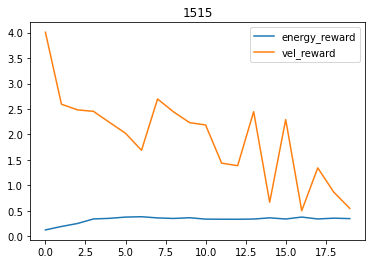

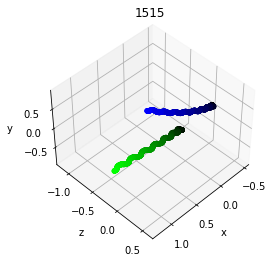

| eval  | E: 83 | S: 1515 | R: 31.9401
| train | E: 84 | S: 1515 | R: 17.2837 | D: 19.2 s | BR: 1.4986 | ALOSS: -20.8854 | CLOSS: 18.8651 | TLOSS: -2.7744 | TVAL: 0.6401 | AENT: -4.0000
| train | E: 85 | S: 1532 | R: 23.6832 | D: 46.5 s | BR: 1.4857 | ALOSS: -20.8893 | CLOSS: 18.5351 | TLOSS: -2.8356 | TVAL: 0.6372 | AENT: -4.0000
| train | E: 86 | S: 1547 | R: 22.9700 | D: 19.3 s | BR: 1.4367 | ALOSS: -20.6128 | CLOSS: 21.9176 | TLOSS: -2.8429 | TVAL: 0.6343 | AENT: -4.0000
| train | E: 87 | S: 1567 | R: 30.5923 | D: 25.8 s | BR: 1.5094 | ALOSS: -21.0515 | CLOSS: 19.1596 | TLOSS: -2.8885 | TVAL: 0.6311 | AENT: -4.0000
| train | E: 88 | S: 1586 | R: 30.0991 | D: 22.9 s | BR: 1.5048 | ALOSS: -21.3829 | CLOSS: 18.6093 | TLOSS: -2.9550 | TVAL: 0.6275 | AENT: -4.0000
| train | E: 89 | S: 1603 | R: 24.2993 | D: 22.8 s | BR: 1.5101 | ALOSS: -21.3479 | CLOSS: 18.3422 | TLOSS: -2.9576 | TVAL: 0.6242 | AENT: -4.0000
| train | E: 90 | S: 1622 | R: 28.6848 | D: 23.9 s | BR: 1.4800 | ALOSS: -21.55

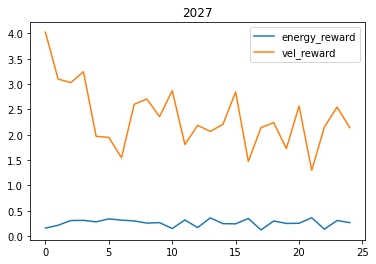

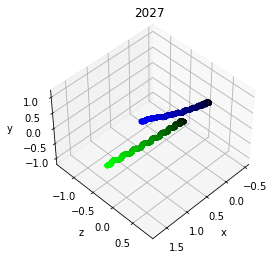

| eval  | E: 111 | S: 2027 | R: 52.2239
| train | E: 112 | S: 2027 | R: 36.3505 | D: 24.2 s | BR: 1.4681 | ALOSS: -23.5189 | CLOSS: 23.4958 | TLOSS: -3.5909 | TVAL: 0.5526 | AENT: -4.0000
| train | E: 113 | S: 2044 | R: 22.7986 | D: 52.6 s | BR: 1.5298 | ALOSS: -23.8394 | CLOSS: 27.6274 | TLOSS: -3.6169 | TVAL: 0.5497 | AENT: -4.0000
| train | E: 114 | S: 2062 | R: 26.5914 | D: 23.7 s | BR: 1.4867 | ALOSS: -24.0277 | CLOSS: 22.3305 | TLOSS: -3.6530 | TVAL: 0.5470 | AENT: -4.0000
| train | E: 115 | S: 2080 | R: 24.9025 | D: 22.0 s | BR: 1.5334 | ALOSS: -23.7249 | CLOSS: 30.6359 | TLOSS: -3.6327 | TVAL: 0.5442 | AENT: -4.0000
| train | E: 116 | S: 2102 | R: 34.6777 | D: 28.1 s | BR: 1.5017 | ALOSS: -24.3067 | CLOSS: 21.7671 | TLOSS: -3.6052 | TVAL: 0.5411 | AENT: -4.0000
| train | E: 117 | S: 2124 | R: 37.5184 | D: 26.1 s | BR: 1.5479 | ALOSS: -24.4238 | CLOSS: 25.1540 | TLOSS: -3.7015 | TVAL: 0.5378 | AENT: -4.0000
| train | E: 118 | S: 2139 | R: 20.2249 | D: 20.5 s | BR: 1.4354 | ALOSS

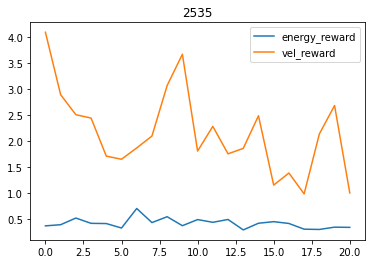

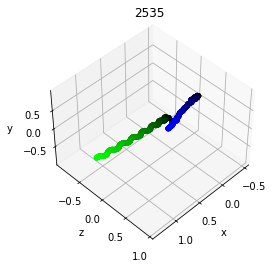

| eval  | E: 135 | S: 2535 | R: 36.8687
| train | E: 136 | S: 2535 | R: 60.6374 | D: 41.5 s | BR: 1.5008 | ALOSS: -26.3034 | CLOSS: 26.6964 | TLOSS: -4.0822 | TVAL: 0.4806 | AENT: -4.0000
| train | E: 137 | S: 2559 | R: 39.2530 | D: 55.8 s | BR: 1.4862 | ALOSS: -26.1621 | CLOSS: 29.3579 | TLOSS: -4.0888 | TVAL: 0.4768 | AENT: -4.0000
| train | E: 138 | S: 2576 | R: 22.4037 | D: 21.8 s | BR: 1.5824 | ALOSS: -26.6830 | CLOSS: 29.5049 | TLOSS: -4.2523 | TVAL: 0.4741 | AENT: -4.0000
| train | E: 139 | S: 2600 | R: 44.5701 | D: 29.2 s | BR: 1.5546 | ALOSS: -26.5244 | CLOSS: 28.5697 | TLOSS: -4.1818 | TVAL: 0.4714 | AENT: -4.0000
| train | E: 140 | S: 2616 | R: 20.9514 | D: 22.0 s | BR: 1.5288 | ALOSS: -27.0096 | CLOSS: 28.3467 | TLOSS: -4.1266 | TVAL: 0.4689 | AENT: -4.0000
| train | E: 141 | S: 2638 | R: 32.6399 | D: 26.6 s | BR: 1.5328 | ALOSS: -26.7060 | CLOSS: 32.0095 | TLOSS: -4.1627 | TVAL: 0.4665 | AENT: -4.0000
| train | E: 142 | S: 2661 | R: 37.0714 | D: 28.1 s | BR: 1.5149 | ALOSS

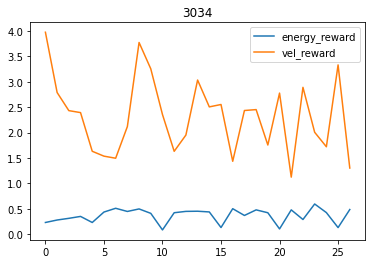

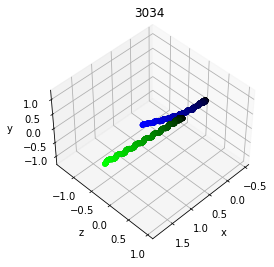

| eval  | E: 157 | S: 3034 | R: 52.6187
| train | E: 158 | S: 3034 | R: 54.5937 | D: 33.5 s | BR: 1.5502 | ALOSS: -28.1021 | CLOSS: 28.4986 | TLOSS: -4.6337 | TVAL: 0.4194 | AENT: -4.0000
| train | E: 159 | S: 3067 | R: 64.7311 | D: 68.8 s | BR: 1.5497 | ALOSS: -28.1092 | CLOSS: 34.3164 | TLOSS: -4.6131 | TVAL: 0.4159 | AENT: -4.0000
| train | E: 160 | S: 3088 | R: 36.8423 | D: 25.8 s | BR: 1.5704 | ALOSS: -28.5511 | CLOSS: 32.0305 | TLOSS: -4.4560 | TVAL: 0.4129 | AENT: -4.0000
| train | E: 161 | S: 3112 | R: 40.6748 | D: 28.6 s | BR: 1.5448 | ALOSS: -28.5900 | CLOSS: 31.8060 | TLOSS: -4.6148 | TVAL: 0.4104 | AENT: -4.0000
| train | E: 162 | S: 3135 | R: 39.0240 | D: 28.0 s | BR: 1.5973 | ALOSS: -28.5688 | CLOSS: 31.2520 | TLOSS: -4.6900 | TVAL: 0.4078 | AENT: -4.0000
| train | E: 163 | S: 3165 | R: 59.7855 | D: 36.3 s | BR: 1.6035 | ALOSS: -28.6317 | CLOSS: 36.5830 | TLOSS: -4.7254 | TVAL: 0.4049 | AENT: -4.0000
| train | E: 164 | S: 3196 | R: 57.0911 | D: 36.8 s | BR: 1.5147 | ALOSS

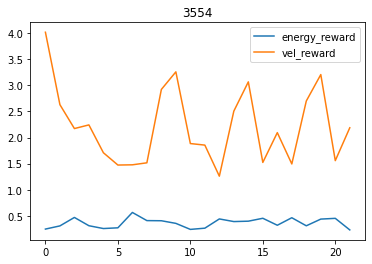

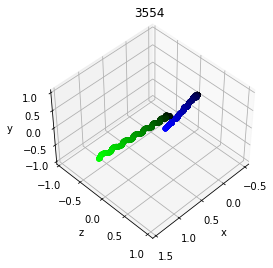

| eval  | E: 178 | S: 3554 | R: 40.7536
| train | E: 179 | S: 3554 | R: 102.8038 | D: 77.7 s | BR: 1.5690 | ALOSS: -29.7052 | CLOSS: 35.5014 | TLOSS: -4.8843 | TVAL: 0.3659 | AENT: -4.0000
| train | E: 180 | S: 3584 | R: 55.3307 | D: 63.3 s | BR: 1.5715 | ALOSS: -29.9403 | CLOSS: 34.3008 | TLOSS: -4.9556 | TVAL: 0.3621 | AENT: -4.0000
| train | E: 181 | S: 3611 | R: 54.1892 | D: 34.1 s | BR: 1.5807 | ALOSS: -29.8403 | CLOSS: 35.7148 | TLOSS: -4.9304 | TVAL: 0.3594 | AENT: -4.0000
| train | E: 182 | S: 3629 | R: 27.9581 | D: 22.3 s | BR: 1.5338 | ALOSS: -30.1134 | CLOSS: 34.6772 | TLOSS: -5.0618 | TVAL: 0.3572 | AENT: -4.0000
| train | E: 183 | S: 3656 | R: 48.2088 | D: 34.1 s | BR: 1.5673 | ALOSS: -30.1526 | CLOSS: 34.4282 | TLOSS: -4.9668 | TVAL: 0.3551 | AENT: -4.0000
| train | E: 184 | S: 3687 | R: 63.2365 | D: 37.8 s | BR: 1.5472 | ALOSS: -30.1208 | CLOSS: 40.9542 | TLOSS: -5.0449 | TVAL: 0.3524 | AENT: -4.0000
| train | E: 185 | S: 3713 | R: 45.3021 | D: 32.2 s | BR: 1.5746 | ALOS

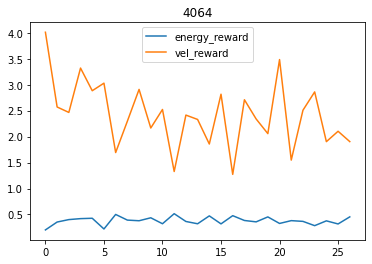

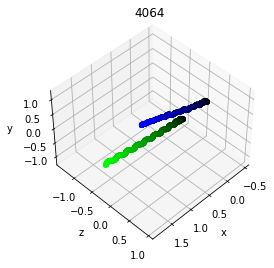

| eval  | E: 197 | S: 4064 | R: 55.0585
| train | E: 198 | S: 4064 | R: 46.3212 | D: 30.6 s | BR: 1.6261 | ALOSS: -31.1819 | CLOSS: 40.2594 | TLOSS: -5.3293 | TVAL: 0.3184 | AENT: -4.0000
| train | E: 199 | S: 4081 | R: 25.5077 | D: 54.7 s | BR: 1.6617 | ALOSS: -31.2175 | CLOSS: 38.9951 | TLOSS: -5.3926 | TVAL: 0.3167 | AENT: -4.0000
| train | E: 200 | S: 4103 | R: 40.4164 | D: 26.3 s | BR: 1.6683 | ALOSS: -31.1449 | CLOSS: 37.9009 | TLOSS: -5.2447 | TVAL: 0.3150 | AENT: -4.0000
| train | E: 201 | S: 4128 | R: 46.4063 | D: 31.0 s | BR: 1.5968 | ALOSS: -31.3263 | CLOSS: 35.2009 | TLOSS: -5.3078 | TVAL: 0.3131 | AENT: -4.0000
| train | E: 202 | S: 4148 | R: 32.2236 | D: 25.2 s | BR: 1.6364 | ALOSS: -31.2508 | CLOSS: 38.7083 | TLOSS: -5.4570 | TVAL: 0.3112 | AENT: -4.0000
| train | E: 203 | S: 4170 | R: 34.5908 | D: 28.8 s | BR: 1.6457 | ALOSS: -31.6133 | CLOSS: 37.3743 | TLOSS: -5.3875 | TVAL: 0.3094 | AENT: -4.0000
| train | E: 204 | S: 4195 | R: 44.2086 | D: 29.4 s | BR: 1.5799 | ALOSS

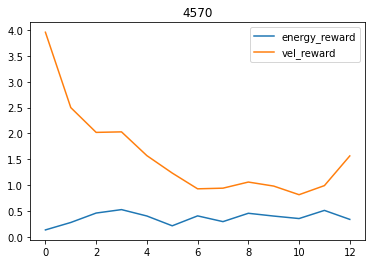

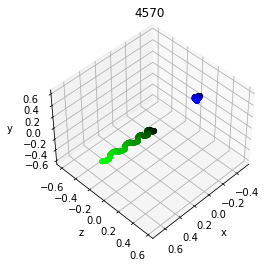

| eval  | E: 217 | S: 4570 | R: 15.8403
| train | E: 218 | S: 4570 | R: 61.2292 | D: 34.0 s | BR: 1.6570 | ALOSS: -32.1160 | CLOSS: 40.0499 | TLOSS: -5.5743 | TVAL: 0.2789 | AENT: -4.0000
| train | E: 219 | S: 4586 | R: 24.1461 | D: 39.5 s | BR: 1.6471 | ALOSS: -32.1510 | CLOSS: 48.4665 | TLOSS: -5.3774 | TVAL: 0.2772 | AENT: -4.0000
| train | E: 220 | S: 4613 | R: 48.0901 | D: 34.4 s | BR: 1.6271 | ALOSS: -32.1891 | CLOSS: 41.3792 | TLOSS: -5.2951 | TVAL: 0.2757 | AENT: -4.0000
| train | E: 221 | S: 4644 | R: 58.5806 | D: 35.5 s | BR: 1.6201 | ALOSS: -32.5732 | CLOSS: 40.0521 | TLOSS: -5.2935 | TVAL: 0.2737 | AENT: -4.0000
| train | E: 222 | S: 4689 | R: 101.7054 | D: 54.0 s | BR: 1.6661 | ALOSS: -32.6747 | CLOSS: 37.3830 | TLOSS: -5.2296 | TVAL: 0.2711 | AENT: -4.0000
| train | E: 223 | S: 4720 | R: 61.6758 | D: 35.2 s | BR: 1.6874 | ALOSS: -32.7698 | CLOSS: 40.3829 | TLOSS: -5.4711 | TVAL: 0.2685 | AENT: -4.0000
| train | E: 224 | S: 4750 | R: 61.7214 | D: 37.7 s | BR: 1.6796 | ALOS

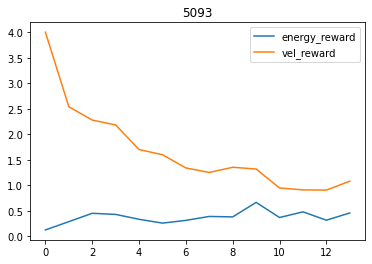

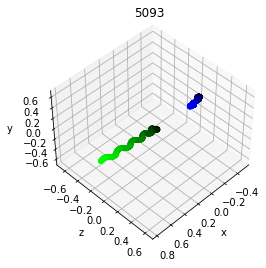

| eval  | E: 235 | S: 5093 | R: 18.1534
| train | E: 236 | S: 5093 | R: 60.9666 | D: 40.3 s | BR: 1.6662 | ALOSS: -33.7483 | CLOSS: 41.7563 | TLOSS: -5.2813 | TVAL: 0.2444 | AENT: -4.0000
| train | E: 237 | S: 5119 | R: 45.3672 | D: 50.4 s | BR: 1.7016 | ALOSS: -33.3583 | CLOSS: 46.3772 | TLOSS: -5.1738 | TVAL: 0.2427 | AENT: -4.0000
| train | E: 238 | S: 5142 | R: 41.9049 | D: 27.5 s | BR: 1.7402 | ALOSS: -33.7955 | CLOSS: 50.0100 | TLOSS: -5.0363 | TVAL: 0.2413 | AENT: -4.0000
| train | E: 239 | S: 5158 | R: 22.3408 | D: 23.0 s | BR: 1.7134 | ALOSS: -34.1480 | CLOSS: 35.6624 | TLOSS: -5.2478 | TVAL: 0.2402 | AENT: -4.0000
| train | E: 240 | S: 5208 | R: 111.1313 | D: 77.2 s | BR: 1.7012 | ALOSS: -33.9800 | CLOSS: 41.3272 | TLOSS: -5.2393 | TVAL: 0.2383 | AENT: -4.0000
| train | E: 241 | S: 5230 | R: 39.5963 | D: 26.4 s | BR: 1.7394 | ALOSS: -34.0660 | CLOSS: 45.0021 | TLOSS: -5.2332 | TVAL: 0.2362 | AENT: -4.0000
| train | E: 242 | S: 5257 | R: 50.6546 | D: 31.4 s | BR: 1.6860 | ALOS

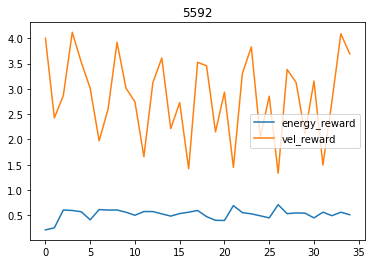

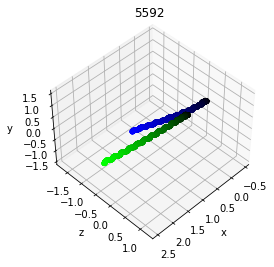

| eval  | E: 251 | S: 5592 | R: 81.3298
| train | E: 252 | S: 5592 | R: 80.3128 | D: 43.3 s | BR: 1.7176 | ALOSS: -35.0339 | CLOSS: 37.3484 | TLOSS: -5.2666 | TVAL: 0.2166 | AENT: -4.0000
| train | E: 253 | S: 5638 | R: 100.1619 | D: 92.2 s | BR: 1.7620 | ALOSS: -34.6706 | CLOSS: 51.0054 | TLOSS: -5.2997 | TVAL: 0.2143 | AENT: -4.0000
| train | E: 254 | S: 5688 | R: 124.4546 | D: 60.4 s | BR: 1.7002 | ALOSS: -35.1202 | CLOSS: 45.6588 | TLOSS: -5.1036 | TVAL: 0.2118 | AENT: -4.0000
| train | E: 255 | S: 5710 | R: 37.2331 | D: 26.6 s | BR: 1.6561 | ALOSS: -35.0182 | CLOSS: 42.1636 | TLOSS: -5.0894 | TVAL: 0.2100 | AENT: -4.0000
| train | E: 256 | S: 5748 | R: 77.3152 | D: 46.7 s | BR: 1.7285 | ALOSS: -35.5976 | CLOSS: 40.2820 | TLOSS: -5.2114 | TVAL: 0.2085 | AENT: -4.0000
| train | E: 257 | S: 5782 | R: 71.1063 | D: 38.4 s | BR: 1.7517 | ALOSS: -35.2657 | CLOSS: 47.9495 | TLOSS: -5.3956 | TVAL: 0.2067 | AENT: -4.0000
| train | E: 258 | S: 5824 | R: 89.3916 | D: 50.3 s | BR: 1.7447 | ALO

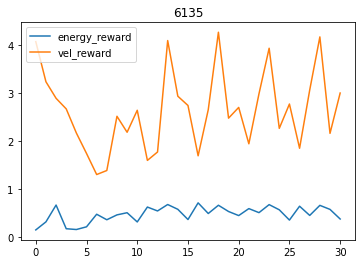

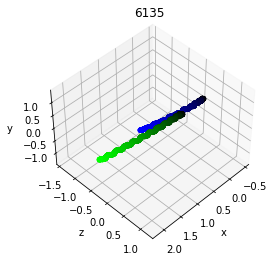

| eval  | E: 267 | S: 6135 | R: 67.0779
| train | E: 268 | S: 6135 | R: 111.2140 | D: 70.8 s | BR: 1.7495 | ALOSS: -36.0073 | CLOSS: 47.6196 | TLOSS: -4.9944 | TVAL: 0.1904 | AENT: -4.0000
| train | E: 269 | S: 6152 | R: 26.4983 | D: 89.6 s | BR: 1.7791 | ALOSS: -36.2638 | CLOSS: 36.7328 | TLOSS: -5.0106 | TVAL: 0.1889 | AENT: -4.0000
| train | E: 270 | S: 6190 | R: 85.2953 | D: 46.2 s | BR: 1.7604 | ALOSS: -35.9984 | CLOSS: 45.4823 | TLOSS: -4.8058 | TVAL: 0.1876 | AENT: -4.0000
| train | E: 271 | S: 6220 | R: 61.4690 | D: 37.2 s | BR: 1.7555 | ALOSS: -36.3182 | CLOSS: 46.0171 | TLOSS: -5.1324 | TVAL: 0.1862 | AENT: -4.0000
| train | E: 272 | S: 6248 | R: 53.9782 | D: 31.8 s | BR: 1.7434 | ALOSS: -36.0938 | CLOSS: 49.2084 | TLOSS: -5.0151 | TVAL: 0.1849 | AENT: -4.0000
| train | E: 273 | S: 6280 | R: 62.8828 | D: 40.2 s | BR: 1.7259 | ALOSS: -36.3054 | CLOSS: 48.5211 | TLOSS: -4.9887 | TVAL: 0.1835 | AENT: -4.0000
| train | E: 274 | S: 6308 | R: 53.1365 | D: 33.2 s | BR: 1.7684 | ALOS

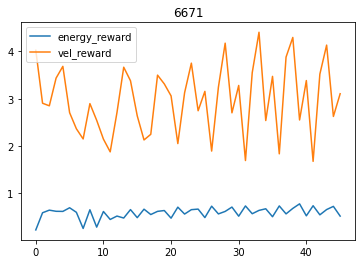

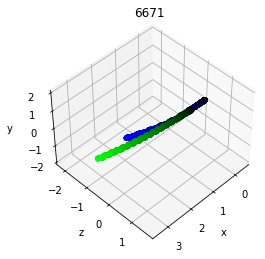

| eval  | E: 284 | S: 6671 | R: 109.7838
| train | E: 285 | S: 6671 | R: 93.8966 | D: 50.2 s | BR: 1.7595 | ALOSS: -36.9482 | CLOSS: 45.8587 | TLOSS: -4.6487 | TVAL: 0.1676 | AENT: -4.0000
| train | E: 286 | S: 6697 | R: 47.4224 | D: 83.7 s | BR: 1.7787 | ALOSS: -37.3604 | CLOSS: 41.6202 | TLOSS: -4.7507 | TVAL: 0.1663 | AENT: -4.0000
| train | E: 287 | S: 6736 | R: 79.3608 | D: 43.4 s | BR: 1.7697 | ALOSS: -37.4403 | CLOSS: 42.3106 | TLOSS: -4.5521 | TVAL: 0.1650 | AENT: -4.0000
| train | E: 288 | S: 6769 | R: 64.6519 | D: 41.8 s | BR: 1.7460 | ALOSS: -37.2435 | CLOSS: 45.2672 | TLOSS: -4.7997 | TVAL: 0.1637 | AENT: -4.0000
| train | E: 289 | S: 6819 | R: 111.2883 | D: 55.3 s | BR: 1.7831 | ALOSS: -37.8348 | CLOSS: 42.1437 | TLOSS: -4.6221 | TVAL: 0.1621 | AENT: -4.0000
| train | E: 290 | S: 6864 | R: 99.1021 | D: 53.4 s | BR: 1.7673 | ALOSS: -37.7458 | CLOSS: 42.4367 | TLOSS: -4.9561 | TVAL: 0.1603 | AENT: -4.0000
| train | E: 291 | S: 6911 | R: 108.4349 | D: 51.9 s | BR: 1.7988 | AL

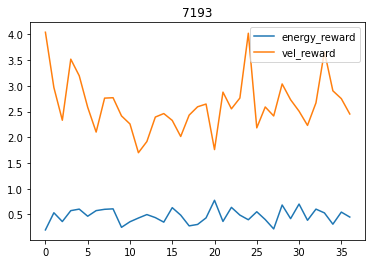

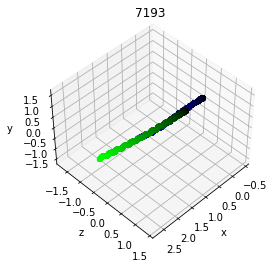

| eval  | E: 299 | S: 7193 | R: 80.0998
| train | E: 300 | S: 7193 | R: 73.9233 | D: 45.2 s | BR: 1.7801 | ALOSS: -37.9778 | CLOSS: 52.0095 | TLOSS: -4.5640 | TVAL: 0.1484 | AENT: -4.0000
| train | E: 301 | S: 7225 | R: 65.5629 | D: 84.4 s | BR: 1.8016 | ALOSS: -38.1815 | CLOSS: 48.4233 | TLOSS: -4.7266 | TVAL: 0.1472 | AENT: -4.0000
| train | E: 302 | S: 7262 | R: 82.6438 | D: 41.7 s | BR: 1.7731 | ALOSS: -38.1119 | CLOSS: 41.5253 | TLOSS: -4.4860 | TVAL: 0.1461 | AENT: -4.0000
| train | E: 303 | S: 7287 | R: 46.7244 | D: 31.0 s | BR: 1.7542 | ALOSS: -37.9537 | CLOSS: 51.0253 | TLOSS: -4.5821 | TVAL: 0.1450 | AENT: -4.0000
| train | E: 304 | S: 7337 | R: 108.8546 | D: 56.9 s | BR: 1.8367 | ALOSS: -38.4488 | CLOSS: 44.4653 | TLOSS: -4.3778 | TVAL: 0.1437 | AENT: -4.0000
| train | E: 305 | S: 7355 | R: 28.1870 | D: 24.7 s | BR: 1.8197 | ALOSS: -38.2026 | CLOSS: 46.7471 | TLOSS: -4.3913 | TVAL: 0.1427 | AENT: -4.0000
| train | E: 306 | S: 7382 | R: 50.6945 | D: 32.2 s | BR: 1.7743 | ALOS

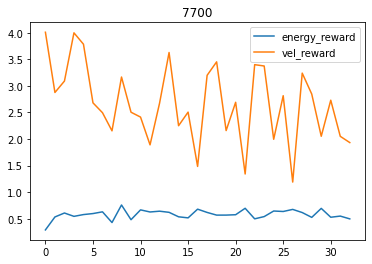

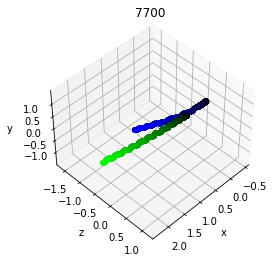

| eval  | E: 314 | S: 7700 | R: 68.9480
| train | E: 315 | S: 7700 | R: 74.9715 | D: 47.1 s | BR: 1.7719 | ALOSS: -39.0878 | CLOSS: 49.5453 | TLOSS: -4.3106 | TVAL: 0.1324 | AENT: -4.0000
| train | E: 316 | S: 7743 | R: 96.8046 | D: 91.0 s | BR: 1.8332 | ALOSS: -39.1541 | CLOSS: 48.6299 | TLOSS: -4.2201 | TVAL: 0.1312 | AENT: -4.0000
| train | E: 317 | S: 7793 | R: 108.7539 | D: 55.3 s | BR: 1.7815 | ALOSS: -39.2910 | CLOSS: 43.3472 | TLOSS: -3.9483 | TVAL: 0.1299 | AENT: -4.0000
| train | E: 318 | S: 7821 | R: 56.6578 | D: 34.1 s | BR: 1.8168 | ALOSS: -39.3513 | CLOSS: 50.8934 | TLOSS: -4.0648 | TVAL: 0.1288 | AENT: -4.0000
| train | E: 319 | S: 7850 | R: 52.0153 | D: 32.9 s | BR: 1.7464 | ALOSS: -39.4480 | CLOSS: 44.0896 | TLOSS: -4.0812 | TVAL: 0.1280 | AENT: -4.0000
| train | E: 320 | S: 7891 | R: 91.6609 | D: 48.8 s | BR: 1.8189 | ALOSS: -39.5631 | CLOSS: 46.1389 | TLOSS: -4.1166 | TVAL: 0.1270 | AENT: -4.0000
| train | E: 321 | S: 7927 | R: 78.2785 | D: 41.0 s | BR: 1.8299 | ALOS

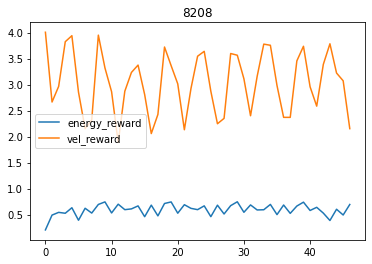

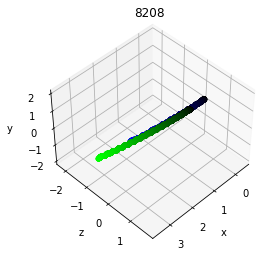

| eval  | E: 329 | S: 8208 | R: 114.9554
| train | E: 330 | S: 8208 | R: 84.2011 | D: 43.5 s | BR: 1.8304 | ALOSS: -40.0681 | CLOSS: 49.5692 | TLOSS: -3.8876 | TVAL: 0.1183 | AENT: -4.0000
| train | E: 331 | S: 8247 | R: 84.4969 | D: 99.7 s | BR: 1.8052 | ALOSS: -39.9505 | CLOSS: 54.5264 | TLOSS: -3.9149 | TVAL: 0.1172 | AENT: -4.0000
| train | E: 332 | S: 8278 | R: 64.8314 | D: 35.0 s | BR: 1.8040 | ALOSS: -40.0994 | CLOSS: 50.9082 | TLOSS: -3.4233 | TVAL: 0.1163 | AENT: -4.0000
| train | E: 333 | S: 8304 | R: 51.3002 | D: 30.6 s | BR: 1.8152 | ALOSS: -40.4288 | CLOSS: 40.8660 | TLOSS: -4.0964 | TVAL: 0.1157 | AENT: -4.0000
| train | E: 334 | S: 8338 | R: 70.8016 | D: 38.2 s | BR: 1.8458 | ALOSS: -40.6618 | CLOSS: 41.4343 | TLOSS: -3.8951 | TVAL: 0.1149 | AENT: -4.0000
| train | E: 335 | S: 8374 | R: 80.7388 | D: 41.4 s | BR: 1.8076 | ALOSS: -40.6164 | CLOSS: 50.2687 | TLOSS: -3.5221 | TVAL: 0.1140 | AENT: -4.0000
| train | E: 336 | S: 8417 | R: 96.1791 | D: 46.9 s | BR: 1.8177 | ALOS

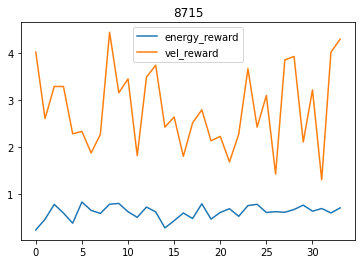

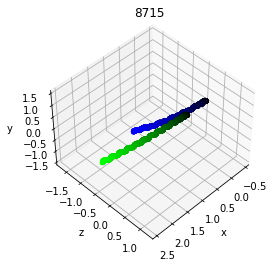

| eval  | E: 345 | S: 8715 | R: 75.0124
| train | E: 346 | S: 8715 | R: 63.9683 | D: 37.0 s | BR: 1.8241 | ALOSS: -40.7991 | CLOSS: 60.2811 | TLOSS: -3.2321 | TVAL: 0.1065 | AENT: -4.0000
| train | E: 347 | S: 8765 | R: 109.8539 | D: 98.4 s | BR: 1.8428 | ALOSS: -40.9822 | CLOSS: 51.4562 | TLOSS: -3.1225 | TVAL: 0.1056 | AENT: -4.0000
| train | E: 348 | S: 8789 | R: 41.9793 | D: 30.8 s | BR: 1.8279 | ALOSS: -41.3564 | CLOSS: 49.7468 | TLOSS: -2.4663 | TVAL: 0.1049 | AENT: -4.0000
| train | E: 349 | S: 8827 | R: 83.9847 | D: 42.3 s | BR: 1.8152 | ALOSS: -40.8958 | CLOSS: 56.8561 | TLOSS: -3.0072 | TVAL: 0.1043 | AENT: -4.0000
| train | E: 350 | S: 8854 | R: 49.9564 | D: 31.7 s | BR: 1.8687 | ALOSS: -41.3567 | CLOSS: 61.3493 | TLOSS: -3.0374 | TVAL: 0.1037 | AENT: -4.0000
| train | E: 351 | S: 8879 | R: 46.8729 | D: 31.2 s | BR: 1.8209 | ALOSS: -41.5390 | CLOSS: 47.7073 | TLOSS: -3.1996 | TVAL: 0.1032 | AENT: -4.0000
| train | E: 352 | S: 8908 | R: 57.6459 | D: 33.0 s | BR: 1.8304 | ALOS

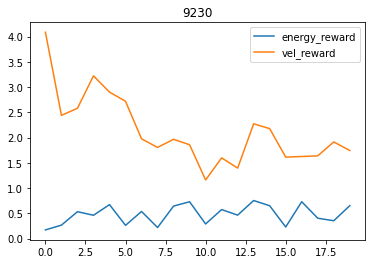

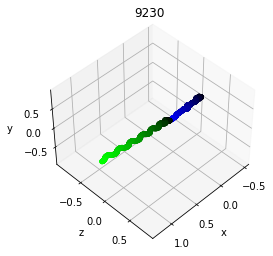

| eval  | E: 360 | S: 9230 | R: 33.0912
| train | E: 361 | S: 9230 | R: 119.5376 | D: 55.1 s | BR: 1.8432 | ALOSS: -41.7814 | CLOSS: 53.6013 | TLOSS: -2.5447 | TVAL: 0.0964 | AENT: -4.0000
| train | E: 362 | S: 9243 | R: 17.1697 | D: 42.9 s | BR: 1.8347 | ALOSS: -42.6434 | CLOSS: 33.8641 | TLOSS: -2.1339 | TVAL: 0.0959 | AENT: -4.0000
| train | E: 363 | S: 9272 | R: 58.2657 | D: 35.6 s | BR: 1.8550 | ALOSS: -41.9217 | CLOSS: 47.3981 | TLOSS: -2.9484 | TVAL: 0.0956 | AENT: -4.0000
| train | E: 364 | S: 9290 | R: 27.0765 | D: 38.3 s | BR: 1.8954 | ALOSS: -41.9751 | CLOSS: 59.5544 | TLOSS: -3.1734 | TVAL: 0.0951 | AENT: -4.0000
| train | E: 365 | S: 9312 | R: 39.2337 | D: 28.4 s | BR: 1.8607 | ALOSS: -42.3525 | CLOSS: 54.2829 | TLOSS: -2.9351 | TVAL: 0.0947 | AENT: -4.0000
| train | E: 366 | S: 9328 | R: 22.1482 | D: 20.7 s | BR: 1.8146 | ALOSS: -41.9613 | CLOSS: 54.5945 | TLOSS: -3.5413 | TVAL: 0.0944 | AENT: -4.0000
| train | E: 367 | S: 9353 | R: 46.2978 | D: 31.5 s | BR: 1.8287 | ALOS

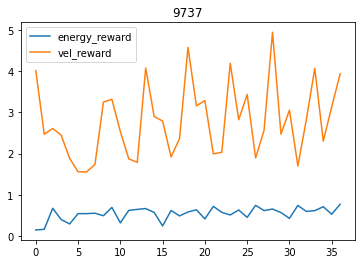

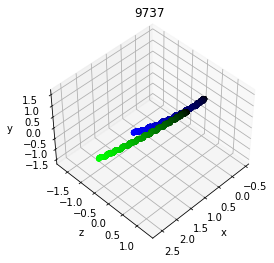

| eval  | E: 379 | S: 9737 | R: 83.1344
| train | E: 380 | S: 9737 | R: 40.3518 | D: 28.7 s | BR: 1.8480 | ALOSS: -42.0204 | CLOSS: 64.4852 | TLOSS: -2.8197 | TVAL: 0.0866 | AENT: -4.0000
| train | E: 381 | S: 9779 | R: 98.0901 | D: 112.7 s | BR: 1.8428 | ALOSS: -42.4444 | CLOSS: 57.3489 | TLOSS: -2.1394 | TVAL: 0.0861 | AENT: -4.0000
| train | E: 382 | S: 9808 | R: 58.0866 | D: 39.5 s | BR: 1.8623 | ALOSS: -42.5740 | CLOSS: 56.1383 | TLOSS: -2.7002 | TVAL: 0.0856 | AENT: -4.0000
| train | E: 383 | S: 9825 | R: 25.7828 | D: 21.2 s | BR: 1.8603 | ALOSS: -43.0597 | CLOSS: 48.3314 | TLOSS: -1.4566 | TVAL: 0.0852 | AENT: -4.0000
| train | E: 384 | S: 9875 | R: 117.8628 | D: 59.5 s | BR: 1.8385 | ALOSS: -42.4976 | CLOSS: 54.7461 | TLOSS: -2.8356 | TVAL: 0.0847 | AENT: -4.0000
| train | E: 385 | S: 9898 | R: 41.0773 | D: 28.3 s | BR: 1.8535 | ALOSS: -42.2274 | CLOSS: 72.3570 | TLOSS: -2.4272 | TVAL: 0.0841 | AENT: -4.0000
| train | E: 386 | S: 9928 | R: 64.6780 | D: 37.4 s | BR: 1.8596 | ALO

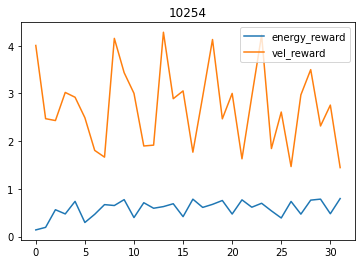

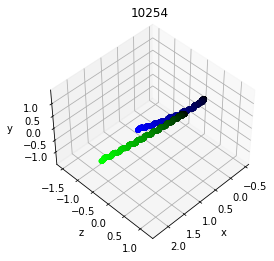

| eval  | E: 394 | S: 10254 | R: 68.6919
| train | E: 395 | S: 10254 | R: 116.6158 | D: 70.2 s | BR: 1.8564 | ALOSS: -42.6088 | CLOSS: 65.5913 | TLOSS: -2.1162 | TVAL: 0.0793 | AENT: -4.0000
| train | E: 396 | S: 10286 | R: 67.3414 | D: 84.0 s | BR: 1.8613 | ALOSS: -42.6550 | CLOSS: 60.6233 | TLOSS: -2.1788 | TVAL: 0.0788 | AENT: -4.0000
| train | E: 397 | S: 10336 | R: 118.7804 | D: 60.4 s | BR: 1.8695 | ALOSS: -43.0542 | CLOSS: 52.2626 | TLOSS: -2.4005 | TVAL: 0.0781 | AENT: -4.0000
| train | E: 398 | S: 10359 | R: 41.5525 | D: 27.3 s | BR: 1.8667 | ALOSS: -42.5624 | CLOSS: 53.4130 | TLOSS: -2.3053 | TVAL: 0.0776 | AENT: -4.0000
| train | E: 399 | S: 10392 | R: 71.3036 | D: 41.2 s | BR: 1.8577 | ALOSS: -43.0587 | CLOSS: 52.2961 | TLOSS: -1.9911 | TVAL: 0.0772 | AENT: -4.0000
| train | E: 400 | S: 10433 | R: 97.9798 | D: 45.6 s | BR: 1.8857 | ALOSS: -42.7914 | CLOSS: 57.2747 | TLOSS: -2.0024 | TVAL: 0.0767 | AENT: -4.0000
| train | E: 401 | S: 10461 | R: 52.8443 | D: 31.9 s | BR: 1.86

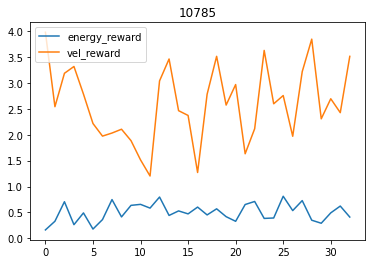

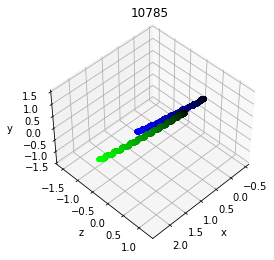

| eval  | E: 410 | S: 10785 | R: 69.4580
| train | E: 411 | S: 10785 | R: 105.2639 | D: 51.1 s | BR: 1.8936 | ALOSS: -43.3243 | CLOSS: 58.7253 | TLOSS: -1.8151 | TVAL: 0.0722 | AENT: -4.0000
| train | E: 412 | S: 10835 | R: 113.5887 | D: 96.7 s | BR: 1.8885 | ALOSS: -43.3270 | CLOSS: 54.9008 | TLOSS: -1.7911 | TVAL: 0.0717 | AENT: -4.0000
| train | E: 413 | S: 10862 | R: 51.5015 | D: 30.8 s | BR: 1.9070 | ALOSS: -43.3349 | CLOSS: 51.0348 | TLOSS: -1.4967 | TVAL: 0.0712 | AENT: -4.0000
| train | E: 414 | S: 10894 | R: 66.2567 | D: 39.0 s | BR: 1.8766 | ALOSS: -43.4114 | CLOSS: 49.0048 | TLOSS: -1.4591 | TVAL: 0.0709 | AENT: -4.0000
| train | E: 415 | S: 10944 | R: 119.6785 | D: 55.4 s | BR: 1.8748 | ALOSS: -43.1926 | CLOSS: 56.0564 | TLOSS: -2.0529 | TVAL: 0.0704 | AENT: -4.0000
| train | E: 416 | S: 10977 | R: 74.1796 | D: 41.4 s | BR: 1.9082 | ALOSS: -43.4112 | CLOSS: 56.3509 | TLOSS: -2.1214 | TVAL: 0.0699 | AENT: -4.0000
| train | E: 417 | S: 11015 | R: 78.9323 | D: 52.0 s | BR: 1.8

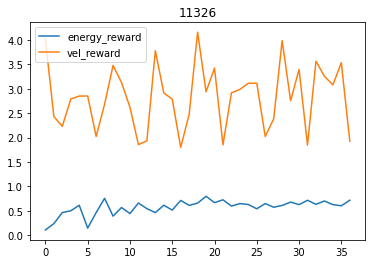

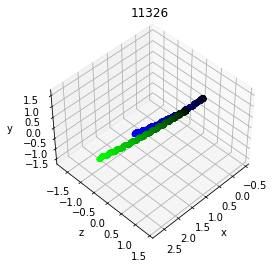

| eval  | E: 424 | S: 11326 | R: 83.7587
| train | E: 425 | S: 11326 | R: 122.9478 | D: 55.4 s | BR: 1.8882 | ALOSS: -43.6649 | CLOSS: 54.9914 | TLOSS: -1.3981 | TVAL: 0.0663 | AENT: -4.0000
| train | E: 426 | S: 11357 | R: 66.8811 | D: 79.6 s | BR: 1.9353 | ALOSS: -43.4610 | CLOSS: 58.2604 | TLOSS: -0.7994 | TVAL: 0.0659 | AENT: -4.0000
| train | E: 427 | S: 11383 | R: 52.0508 | D: 31.3 s | BR: 1.9454 | ALOSS: -43.7684 | CLOSS: 60.7877 | TLOSS: -1.1819 | TVAL: 0.0657 | AENT: -4.0000
| train | E: 428 | S: 11433 | R: 127.1924 | D: 59.9 s | BR: 1.8808 | ALOSS: -43.9176 | CLOSS: 51.5447 | TLOSS: -0.6583 | TVAL: 0.0655 | AENT: -4.0000
| train | E: 429 | S: 11460 | R: 51.5473 | D: 31.2 s | BR: 1.8950 | ALOSS: -43.3816 | CLOSS: 65.5921 | TLOSS: -0.8936 | TVAL: 0.0653 | AENT: -4.0000
| train | E: 430 | S: 11481 | R: 38.7864 | D: 28.0 s | BR: 1.9179 | ALOSS: -43.5264 | CLOSS: 62.1984 | TLOSS: -0.5082 | TVAL: 0.0651 | AENT: -4.0000
| train | E: 431 | S: 11520 | R: 90.5694 | D: 44.3 s | BR: 1.89

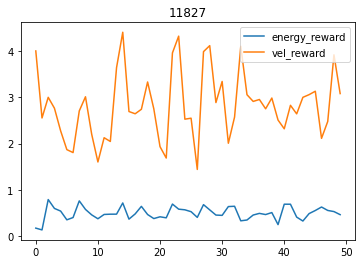

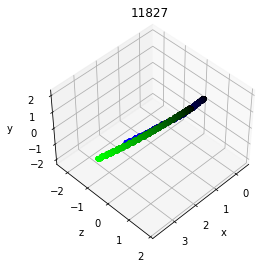

| eval  | E: 439 | S: 11827 | R: 116.5456
| train | E: 440 | S: 11827 | R: 69.4177 | D: 55.7 s | BR: 1.9168 | ALOSS: -43.3570 | CLOSS: 66.1183 | TLOSS: -0.8315 | TVAL: 0.0627 | AENT: -4.0000
| train | E: 441 | S: 11860 | R: 67.5190 | D: 103.3 s | BR: 1.8966 | ALOSS: -43.7546 | CLOSS: 59.4294 | TLOSS: -0.4757 | TVAL: 0.0626 | AENT: -4.0000
| train | E: 442 | S: 11887 | R: 54.2477 | D: 31.6 s | BR: 1.9188 | ALOSS: -43.7458 | CLOSS: 55.2974 | TLOSS: -0.3797 | TVAL: 0.0624 | AENT: -4.0000
| train | E: 443 | S: 11925 | R: 86.8037 | D: 56.5 s | BR: 1.9016 | ALOSS: -43.5672 | CLOSS: 65.7442 | TLOSS: -0.9866 | TVAL: 0.0624 | AENT: -4.0000
| train | E: 444 | S: 11960 | R: 78.3425 | D: 38.7 s | BR: 1.8980 | ALOSS: -43.5909 | CLOSS: 60.2594 | TLOSS: -0.3630 | TVAL: 0.0621 | AENT: -4.0000
| train | E: 445 | S: 11997 | R: 80.1244 | D: 46.1 s | BR: 1.8977 | ALOSS: -43.6125 | CLOSS: 58.2069 | TLOSS: -1.0686 | TVAL: 0.0619 | AENT: -4.0000
| train | E: 446 | S: 12039 | R: 97.1971 | D: 66.4 s | BR: 1.90

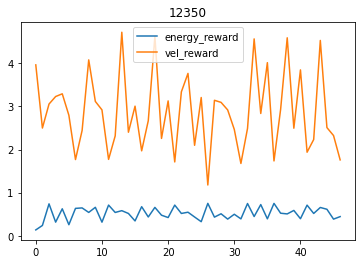

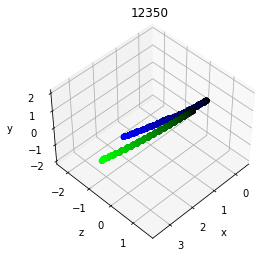

| eval  | E: 453 | S: 12350 | R: 111.1767
| train | E: 454 | S: 12350 | R: 50.7016 | D: 29.0 s | BR: 1.9055 | ALOSS: -44.2549 | CLOSS: 49.5903 | TLOSS: -0.4268 | TVAL: 0.0602 | AENT: -4.0000
| train | E: 455 | S: 12392 | R: 98.5514 | D: 104.6 s | BR: 1.9189 | ALOSS: -43.9962 | CLOSS: 57.5315 | TLOSS: -0.4089 | TVAL: 0.0601 | AENT: -4.0000
| train | E: 456 | S: 12442 | R: 114.1998 | D: 61.2 s | BR: 1.8799 | ALOSS: -43.9243 | CLOSS: 55.5625 | TLOSS: -0.6538 | TVAL: 0.0600 | AENT: -4.0000
| train | E: 457 | S: 12465 | R: 43.2826 | D: 28.5 s | BR: 1.9805 | ALOSS: -44.2067 | CLOSS: 55.2654 | TLOSS: -0.5155 | TVAL: 0.0597 | AENT: -4.0000
| train | E: 458 | S: 12515 | R: 116.8111 | D: 76.2 s | BR: 1.9061 | ALOSS: -44.2333 | CLOSS: 52.9355 | TLOSS: -0.6349 | TVAL: 0.0595 | AENT: -4.0000
| train | E: 459 | S: 12540 | R: 49.3228 | D: 49.3 s | BR: 1.9317 | ALOSS: -44.5173 | CLOSS: 43.7238 | TLOSS: -0.9526 | TVAL: 0.0593 | AENT: -4.0000
| train | E: 460 | S: 12559 | R: 30.0209 | D: 26.4 s | BR: 1.

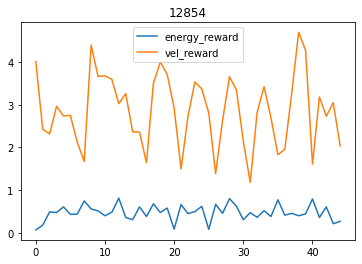

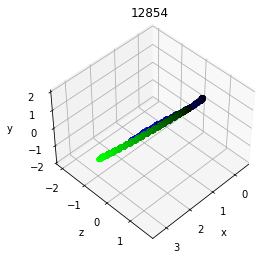

| eval  | E: 467 | S: 12854 | R: 107.8539
| train | E: 468 | S: 12854 | R: 118.4721 | D: 61.6 s | BR: 1.9257 | ALOSS: -43.8809 | CLOSS: 66.4539 | TLOSS: -0.4901 | TVAL: 0.0575 | AENT: -4.0000
| train | E: 469 | S: 12888 | R: 72.4293 | D: 93.5 s | BR: 1.9743 | ALOSS: -44.2439 | CLOSS: 59.6250 | TLOSS: 0.3763 | TVAL: 0.0573 | AENT: -4.0000
| train | E: 470 | S: 12935 | R: 103.7196 | D: 56.5 s | BR: 1.9359 | ALOSS: -44.3368 | CLOSS: 51.0881 | TLOSS: -0.8148 | TVAL: 0.0573 | AENT: -4.0000
| train | E: 471 | S: 12983 | R: 109.5828 | D: 94.0 s | BR: 1.9418 | ALOSS: -44.3624 | CLOSS: 56.0348 | TLOSS: -0.5738 | TVAL: 0.0570 | AENT: -4.0000
| train | E: 472 | S: 13033 | R: 117.6376 | D: 76.3 s | BR: 1.9622 | ALOSS: -44.0430 | CLOSS: 64.2183 | TLOSS: -0.1396 | TVAL: 0.0567 | AENT: -4.0000
| train | E: 473 | S: 13070 | R: 82.3361 | D: 65.8 s | BR: 1.9232 | ALOSS: -43.8634 | CLOSS: 66.6597 | TLOSS: 0.0251 | TVAL: 0.0567 | AENT: -4.0000
| train | E: 474 | S: 13120 | R: 123.8509 | D: 85.4 s | BR: 1.

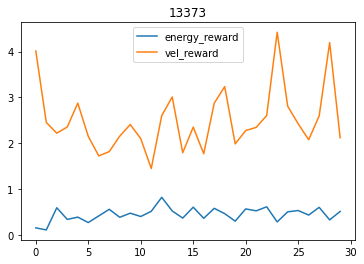

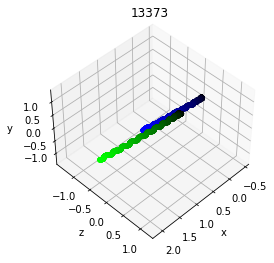

| eval  | E: 481 | S: 13373 | R: 61.7570
| train | E: 482 | S: 13373 | R: 101.6948 | D: 51.0 s | BR: 1.9188 | ALOSS: -44.1749 | CLOSS: 67.8451 | TLOSS: -0.1517 | TVAL: 0.0556 | AENT: -4.0000
| train | E: 483 | S: 13408 | R: 75.5028 | D: 115.0 s | BR: 1.9476 | ALOSS: -44.5239 | CLOSS: 54.5962 | TLOSS: -0.5122 | TVAL: 0.0556 | AENT: -4.0000
| train | E: 484 | S: 13442 | R: 71.8933 | D: 54.6 s | BR: 1.9654 | ALOSS: -44.7116 | CLOSS: 53.0213 | TLOSS: 0.4237 | TVAL: 0.0555 | AENT: -4.0000
| train | E: 485 | S: 13473 | R: 65.0029 | D: 35.4 s | BR: 1.9268 | ALOSS: -44.5936 | CLOSS: 48.2012 | TLOSS: -0.5383 | TVAL: 0.0555 | AENT: -4.0000
| train | E: 486 | S: 13488 | R: 20.6831 | D: 20.5 s | BR: 1.9320 | ALOSS: -44.5887 | CLOSS: 49.4738 | TLOSS: -0.6719 | TVAL: 0.0554 | AENT: -4.0000
| train | E: 487 | S: 13538 | R: 112.5164 | D: 71.4 s | BR: 1.9713 | ALOSS: -44.7446 | CLOSS: 50.5368 | TLOSS: 0.2127 | TVAL: 0.0553 | AENT: -4.0000
| train | E: 488 | S: 13578 | R: 88.1367 | D: 73.0 s | BR: 1.949

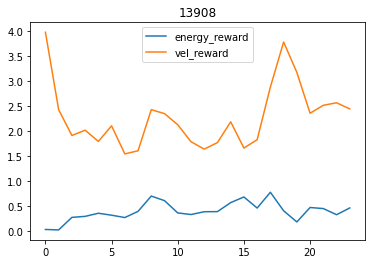

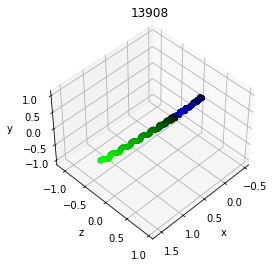

| eval  | E: 496 | S: 13908 | R: 45.4033
| train | E: 497 | S: 13908 | R: 116.1616 | D: 55.4 s | BR: 1.9759 | ALOSS: -44.5398 | CLOSS: 63.1985 | TLOSS: 0.2761 | TVAL: 0.0543 | AENT: -4.0000
| train | E: 498 | S: 13958 | R: 128.0252 | D: 88.2 s | BR: 1.9533 | ALOSS: -44.6634 | CLOSS: 49.1645 | TLOSS: 0.3672 | TVAL: 0.0545 | AENT: -4.0000
| train | E: 499 | S: 14003 | R: 102.6775 | D: 64.7 s | BR: 1.9464 | ALOSS: -44.4306 | CLOSS: 59.5065 | TLOSS: 0.3752 | TVAL: 0.0547 | AENT: -4.0000
| train | E: 500 | S: 14053 | R: 116.1685 | D: 93.8 s | BR: 1.9645 | ALOSS: -44.4008 | CLOSS: 57.2142 | TLOSS: 0.2027 | TVAL: 0.0549 | AENT: -4.0000
| train | E: 501 | S: 14093 | R: 91.2548 | D: 47.8 s | BR: 1.9714 | ALOSS: -44.4805 | CLOSS: 53.8909 | TLOSS: 0.2367 | TVAL: 0.0551 | AENT: -4.0000
| train | E: 502 | S: 14143 | R: 118.3948 | D: 55.0 s | BR: 1.9603 | ALOSS: -44.7440 | CLOSS: 54.1851 | TLOSS: 0.5941 | TVAL: 0.0552 | AENT: -4.0000
| train | E: 503 | S: 14179 | R: 76.0192 | D: 40.0 s | BR: 1.9731 

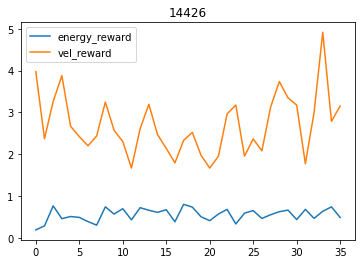

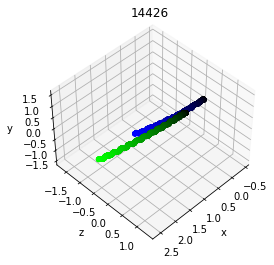

| eval  | E: 507 | S: 14426 | R: 77.3652
| train | E: 508 | S: 14426 | R: 122.6425 | D: 55.0 s | BR: 1.9675 | ALOSS: -44.7570 | CLOSS: 57.3419 | TLOSS: 0.1633 | TVAL: 0.0563 | AENT: -4.0000
| train | E: 509 | S: 14459 | R: 69.2961 | D: 79.1 s | BR: 1.9551 | ALOSS: -44.9487 | CLOSS: 57.3474 | TLOSS: 0.6731 | TVAL: 0.0565 | AENT: -4.0000
| train | E: 510 | S: 14492 | R: 71.9622 | D: 37.1 s | BR: 1.9898 | ALOSS: -45.4367 | CLOSS: 44.0963 | TLOSS: 0.3779 | TVAL: 0.0567 | AENT: -4.0000
| train | E: 511 | S: 14519 | R: 50.9743 | D: 31.8 s | BR: 1.9701 | ALOSS: -44.8318 | CLOSS: 60.9848 | TLOSS: 0.4108 | TVAL: 0.0568 | AENT: -4.0000
| train | E: 512 | S: 14546 | R: 47.6406 | D: 33.9 s | BR: 1.9340 | ALOSS: -45.0989 | CLOSS: 50.8989 | TLOSS: 0.3610 | TVAL: 0.0570 | AENT: -4.0000
| train | E: 513 | S: 14578 | R: 69.7198 | D: 37.4 s | BR: 1.9903 | ALOSS: -45.0655 | CLOSS: 53.0871 | TLOSS: 0.0036 | TVAL: 0.0571 | AENT: -4.0000
| train | E: 514 | S: 14610 | R: 68.8970 | D: 37.3 s | BR: 2.0051 | AL

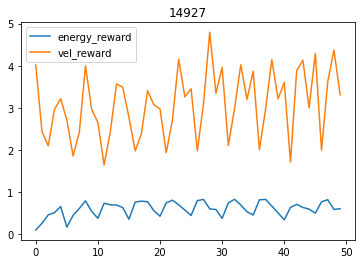

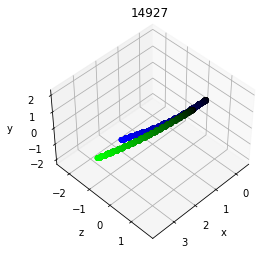

| eval  | E: 520 | S: 14927 | R: 124.0299
| train | E: 521 | S: 14927 | R: 121.8944 | D: 55.1 s | BR: 1.9721 | ALOSS: -45.2570 | CLOSS: 59.0812 | TLOSS: 0.2739 | TVAL: 0.0579 | AENT: -4.0000
| train | E: 522 | S: 14964 | R: 80.1094 | D: 107.5 s | BR: 1.9851 | ALOSS: -45.0144 | CLOSS: 58.3276 | TLOSS: -0.0439 | TVAL: 0.0580 | AENT: -4.0000
| train | E: 523 | S: 15014 | R: 119.4520 | D: 55.2 s | BR: 1.9689 | ALOSS: -45.2731 | CLOSS: 62.4641 | TLOSS: 0.5342 | TVAL: 0.0580 | AENT: -4.0000
| train | E: 524 | S: 15059 | R: 102.5103 | D: 49.6 s | BR: 1.9601 | ALOSS: -45.2986 | CLOSS: 57.2491 | TLOSS: 0.7870 | TVAL: 0.0585 | AENT: -4.0000
| train | E: 525 | S: 15109 | R: 119.8864 | D: 61.0 s | BR: 1.9538 | ALOSS: -45.1576 | CLOSS: 61.6647 | TLOSS: 0.3698 | TVAL: 0.0589 | AENT: -4.0000
| train | E: 526 | S: 15134 | R: 46.0480 | D: 30.0 s | BR: 2.0061 | ALOSS: -45.1618 | CLOSS: 66.1643 | TLOSS: 0.7082 | TVAL: 0.0592 | AENT: -4.0000
| train | E: 527 | S: 15184 | R: 121.5149 | D: 59.0 s | BR: 1.99

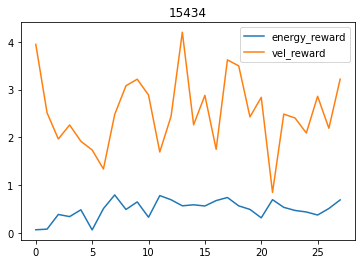

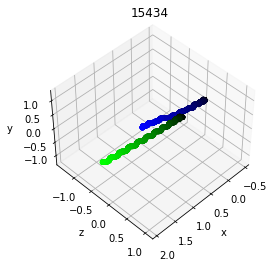

| eval  | E: 531 | S: 15434 | R: 57.1450
| train | E: 532 | S: 15434 | R: 117.9122 | D: 60.3 s | BR: 1.9926 | ALOSS: -45.4647 | CLOSS: 58.8248 | TLOSS: 0.0258 | TVAL: 0.0601 | AENT: -4.0000
| train | E: 533 | S: 15460 | R: 53.5019 | D: 66.1 s | BR: 1.9854 | ALOSS: -45.4200 | CLOSS: 61.8947 | TLOSS: -0.2686 | TVAL: 0.0601 | AENT: -4.0000
| train | E: 534 | S: 15510 | R: 130.4876 | D: 55.2 s | BR: 1.9830 | ALOSS: -45.4839 | CLOSS: 53.6354 | TLOSS: 0.0712 | TVAL: 0.0600 | AENT: -4.0000
| train | E: 535 | S: 15551 | R: 89.9575 | D: 53.2 s | BR: 1.9683 | ALOSS: -45.7492 | CLOSS: 58.1579 | TLOSS: -0.0494 | TVAL: 0.0600 | AENT: -4.0000
| train | E: 536 | S: 15601 | R: 119.7175 | D: 73.0 s | BR: 2.0197 | ALOSS: -45.6668 | CLOSS: 61.0897 | TLOSS: -0.0291 | TVAL: 0.0602 | AENT: -4.0000
| train | E: 537 | S: 15651 | R: 121.2261 | D: 86.4 s | BR: 2.0007 | ALOSS: -45.3189 | CLOSS: 66.7149 | TLOSS: 0.4764 | TVAL: 0.0601 | AENT: -4.0000
| train | E: 538 | S: 15678 | R: 55.5188 | D: 31.5 s | BR: 2.002

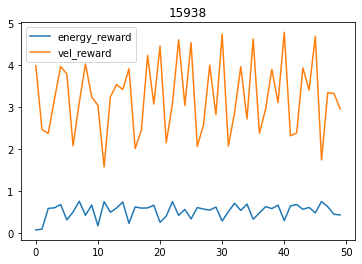

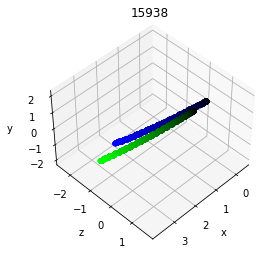

| eval  | E: 543 | S: 15938 | R: 135.8963
| train | E: 544 | S: 15938 | R: 122.7406 | D: 61.2 s | BR: 2.0018 | ALOSS: -45.4870 | CLOSS: 63.8315 | TLOSS: -0.5817 | TVAL: 0.0598 | AENT: -4.0000
| train | E: 545 | S: 15988 | R: 121.0588 | D: 118.1 s | BR: 1.9980 | ALOSS: -45.8544 | CLOSS: 53.2513 | TLOSS: -0.0350 | TVAL: 0.0594 | AENT: -4.0000
| train | E: 546 | S: 16038 | R: 119.7960 | D: 86.1 s | BR: 2.0005 | ALOSS: -45.6624 | CLOSS: 63.8733 | TLOSS: -0.3242 | TVAL: 0.0593 | AENT: -4.0000
| train | E: 547 | S: 16088 | R: 118.9350 | D: 60.3 s | BR: 1.9964 | ALOSS: -45.9080 | CLOSS: 50.1259 | TLOSS: 0.2889 | TVAL: 0.0593 | AENT: -4.0000
| train | E: 548 | S: 16138 | R: 122.4726 | D: 82.3 s | BR: 1.9841 | ALOSS: -45.7974 | CLOSS: 59.8895 | TLOSS: -0.3137 | TVAL: 0.0592 | AENT: -4.0000
| train | E: 549 | S: 16174 | R: 80.8124 | D: 62.5 s | BR: 1.9975 | ALOSS: -45.9816 | CLOSS: 56.0087 | TLOSS: -0.3886 | TVAL: 0.0590 | AENT: -4.0000
| train | E: 550 | S: 16199 | R: 49.2848 | D: 40.9 s | BR: 

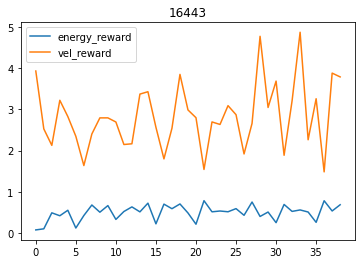

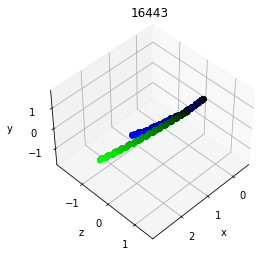

| eval  | E: 554 | S: 16443 | R: 90.8948
| train | E: 555 | S: 16443 | R: 123.1632 | D: 61.6 s | BR: 1.9763 | ALOSS: -46.0209 | CLOSS: 51.7160 | TLOSS: 0.3018 | TVAL: 0.0585 | AENT: -4.0000
| train | E: 556 | S: 16481 | R: 85.4354 | D: 92.0 s | BR: 2.0252 | ALOSS: -45.8615 | CLOSS: 56.8484 | TLOSS: -0.1630 | TVAL: 0.0585 | AENT: -4.0000
| train | E: 557 | S: 16531 | R: 114.0419 | D: 55.1 s | BR: 2.0409 | ALOSS: -45.9604 | CLOSS: 61.8506 | TLOSS: 0.8026 | TVAL: 0.0587 | AENT: -4.0000
| train | E: 558 | S: 16581 | R: 116.5657 | D: 59.4 s | BR: 1.9999 | ALOSS: -45.9356 | CLOSS: 55.4994 | TLOSS: -0.4589 | TVAL: 0.0589 | AENT: -4.0000
| train | E: 559 | S: 16619 | R: 84.5238 | D: 41.8 s | BR: 2.0630 | ALOSS: -46.4435 | CLOSS: 51.4041 | TLOSS: 0.2796 | TVAL: 0.0588 | AENT: -4.0000
| train | E: 560 | S: 16669 | R: 115.7823 | D: 61.5 s | BR: 2.0296 | ALOSS: -46.3781 | CLOSS: 52.2846 | TLOSS: 1.1632 | TVAL: 0.0591 | AENT: -4.0000
| train | E: 561 | S: 16719 | R: 122.5407 | D: 55.3 s | BR: 1.997

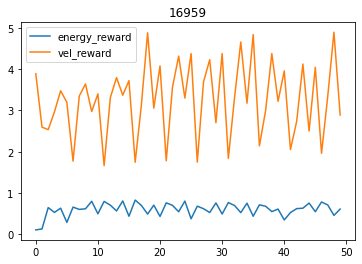

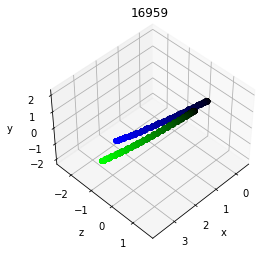

| eval  | E: 565 | S: 16959 | R: 133.9546
| train | E: 566 | S: 16959 | R: 84.3865 | D: 48.4 s | BR: 2.0476 | ALOSS: -46.3987 | CLOSS: 57.4663 | TLOSS: -0.3052 | TVAL: 0.0606 | AENT: -4.0000


KeyboardInterrupt: 

In [26]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [28]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [27]:
network_folder

'/root/pytorch_fish/output_data/2021-05-31/test school with markers   vel follow_2021-05-31 04:10/networks/'

In [33]:
agent.load(model_folder+"steps_{0}".format(35646))

## Evaluation and Test

In [29]:
evaluate_save_fluid=True
evaluate_save_data=True

Evaluating episode 0 ....


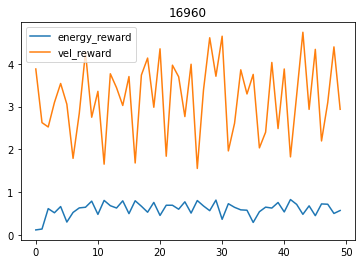

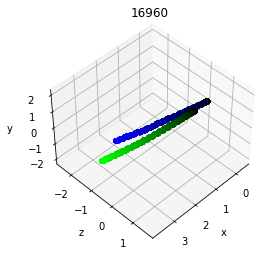

| eval  | E: 0 | S: 16960 | R: 130.5526


In [30]:
evaluate()

In [ ]:
def evaluate_traj(goal_pos,target_vel,step_budget):
#         print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
#         skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
#         skeleton_dynamics.getJoint("head").setVelocity(0,0)
#         skeleton_dynamics.getJoint("head").setVelocity(1,0)
#         joint_list =['spine','spine01','spine02','spine03']
#         for jnt_name in joint_list:
#             skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#             skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


#         skeleton_dynamics.update()
        env.set_task(goal_pos,target_vel,step_budget)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.init_pos*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
#         agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            action, _states = model.predict(obs, deterministic=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
        plot_infos(infos,title="str(theta)")
        env.plot3d()

In [ ]:
!./clean_visdata.sh

thetaa = 0
goal_dir = np.array([math.cos(thetaa),0,math.sin(thetaa)])
goal_pos = goal_dir*1
target_vel = 0.1
budget = 1.0
evaluate_traj(goal_pos,target_vel,budget)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()
t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 

env.set_task(goal_pos ,0.1,1.0)

# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)
# env.set_datapath(store_folder+'/data/')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    action, _states = model.predict(obs, deterministic=True)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=True)
    
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t = t+dt
        env.set_task(traj.getPose(t).getPosition() ,0.1,1.0)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
        
while env.rigid_data.rigidWorld.time<10:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [ ]:
env.couple_mode =  fl.COUPLE_MODE.TWO_WAY
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)

# skeleton_dynamics.update()

t = 0.001
dt = 0.08

startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)


env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
while env.rigid_data.rigidWorld.time<3:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
# plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**2) for a in actions])
plt.plot(np.arange(0,len(actions),1),[ a[1] for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()